In [5]:
pip install pandas pytz matplotlib


  Using cached matplotlib-3.10.5-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.5-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.0-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using ca

In [24]:
import pandas as pd

# Load CSV
df = pd.read_csv("intraday_15min_SPY.csv", parse_dates=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# reverese the DataFrame
df = df.iloc[::-1]

print(df.head())

                       open    high     low   close  volume
timestamp                                                  
2025-07-02 04:00:00  618.50  618.80  618.12  618.62   15586
2025-07-02 04:15:00  618.54  618.70  618.14  618.37   23665
2025-07-02 04:30:00  618.28  618.37  618.01  618.17   14589
2025-07-02 04:45:00  618.22  618.46  618.20  618.25    5062
2025-07-02 05:00:00  618.26  618.34  618.07  618.21    9816


count    21.000000
mean     -0.845488
std       0.448824
min      -1.000000
25%      -1.000000
50%      -1.000000
75%      -1.000000
max       0.777734
Name: pnl, dtype: float64


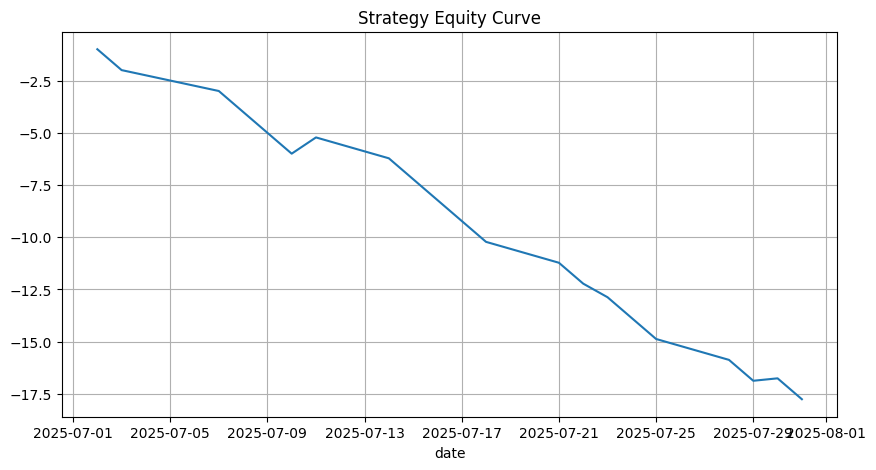

In [8]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt



# Filter only NY session: 9:30 AM to 4:00 PM to get both pre-candle and signal candle
df = df.between_time("09:30", "16:00")

# Group by day
grouped = df.groupby(df.index.date)

results = []
for date, group in grouped:
    if len(group) < 2:
        continue  # skip incomplete days

    pre_candle = group.iloc[0]  # 9:30–9:45
    signal_candle = group.iloc[1]  # 9:45–10:00

    direction = "long" if signal_candle["close"] > signal_candle["open"] else "short"
    entry_price = signal_candle["close"]
    stop = pre_candle["low"] if direction == "long" else pre_candle["high"]
    risk = abs(entry_price - stop)
    target = entry_price + 2 * risk if direction == "long" else entry_price - 2 * risk

    # Simulate trade in following candles of the day
    day_data = df.loc[str(date)]
    if len(day_data) < 3:
        continue  # No data after 9:45

    trade_data = day_data.iloc[2:]  # 10:00 AM onward

    hit_stop = False
    hit_target = False

    for _, row in trade_data.iterrows():
        if direction == "long":
            if row["low"] <= stop:
                hit_stop = True
                break
            elif row["high"] >= target:
                hit_target = True
                break
        else:
            if row["high"] >= stop:
                hit_stop = True
                break
            elif row["low"] <= target:
                hit_target = True
                break

    pnl = 0
    if hit_target:
        pnl = 2  # +2R
    elif hit_stop:
        pnl = -1  # -1R
    else:
        # If neither hit, we assume end-of-day exit
        last_price = trade_data["close"].iloc[-1]
        pnl = (last_price - entry_price) / risk if direction == "long" else (entry_price - last_price) / risk

    results.append({"date": date, "pnl": pnl, "direction": direction})

# Results summary
df_results = pd.DataFrame(results)
df_results.set_index("date", inplace=True)
print(df_results["pnl"].describe())

# Cumulative equity
df_results["equity"] = df_results["pnl"].cumsum()
df_results["equity"].plot(title="Strategy Equity Curve", figsize=(10, 5))
plt.grid()
plt.show()


In [9]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt



# Filter only NY session: 9:30 AM to 4:00 PM to get both pre-candle and signal candle
df = df.between_time("09:30", "16:00")

# Group by day
grouped = df.groupby(df.index.date)

In [27]:
df_ny = df.between_time("09:30", "16:00")
df_ny["Date"] = df_ny.index.date
df_ny["Time"] = df_ny.index.time

df_ny.head()

/tmp/ipykernel_52005/2294673354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ny["Date"] = df_ny.index.date
/tmp/ipykernel_52005/2294673354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ny["Time"] = df_ny.index.time


,open,high,low,close,volume,Date,Time
timestamp,,,,,,,
2025-07-02 09:30:00,617.240,617.49,616.610,617.1350,3207569,2025-07-02,09:30:00
2025-07-02 09:45:00,617.135,617.64,617.095,617.3093,2293387,2025-07-02,09:45:00
2025-07-02 10:00:00,617.310,618.00,617.280,617.9201,2536356,2025-07-02,10:00:00
2025-07-02 10:15:00,617.920,618.72,617.870,618.6000,2655255,2025-07-02,10:15:00
2025-07-02 10:30:00,618.600,619.13,618.240,618.3500,2558451,2025-07-02,10:30:00


In [28]:
# Backtest Strategy

import time

trades = []
cumulative_r = 0

for date, group in df_ny.groupby("Date"):
    triggered = False
    for i in range(1, len(group)):
        prev = group.iloc[i - 1]
        curr = group.iloc[i]
        entry = None
        sl = None
        tp = None
        direction = None
        risk = None

        # Bullish previous
        if prev["close"] > prev["open"]:
            if curr["close"] > prev["close"]:
                direction = "long"
                entry = curr["close"]
                sl = prev["close"]
            elif curr["close"] < prev["open"]:
                direction = "short"
                entry = curr["close"]
                sl = prev["open"]

        # Bearish previous
        elif prev["close"] < prev["open"]:
            if curr["close"] > prev["open"]:
                direction = "long"
                entry = curr["close"]
                sl = prev["open"]
            elif curr["close"] < prev["close"]:
                direction = "short"
                entry = curr["close"]
                sl = prev["close"]

        if direction and not triggered:
            risk = abs(entry - sl)
            tp = entry + 2 * risk if direction == "long" else entry - 2 * risk
            trade_open_time = curr["Time"]

            trade_df = group[group["Time"] > trade_open_time]
            exit_price = group[group["Time"] > trade_open_time].iloc[-1]["close"] if not group[group["Time"] > trade_open_time].empty else entry
            pnl = 0

            for _, row in trade_df.iterrows():
                if direction == "long":
                    if row["low"] <= sl:
                        exit_price = sl
                        pnl = -1
                        break
                    elif row["high"] >= tp:
                        exit_price = tp
                        pnl = 2
                        break
                elif direction == "short":
                    if row["high"] >= sl:
                        exit_price = sl
                        pnl = -1
                        break
                    elif row["low"] <= tp:
                        exit_price = tp
                        pnl = 2
                        break
            else:
                if direction == "long":
                    pnl = (exit_price - entry) / risk
                else:
                    pnl = (entry - exit_price) / risk

            cumulative_r += pnl
            trades.append({
                "date": date,
                "direction": direction,
                "entry": round(entry, 2),
                "exit": round(exit_price, 2),
                "pnl_R": round(pnl, 2),
                "cumulative_R": round(cumulative_r, 2)
            })
            triggered = True

In [ ]:
# backtest strategy

trades = []
cumulative_r = 0
cumulative_abs = 0

for date, group in df_ny.groupby("Date"):
    triggered = False
    for i in range(1, len(group)):
        prev = group.iloc[i - 1]
        curr = group.iloc[i]
        entry = None
        sl = None
        tp = None
        direction = None
        risk = None

        # Bullish previous
        if prev["close"] > prev["open"]:
            if curr["close"] > prev["close"]:
                direction = "long"
                entry = curr["close"]
                sl = prev["close"]
            elif curr["close"] < prev["open"]:
                direction = "short"
                entry = curr["close"]
                sl = prev["open"]

        # Bearish previous
        elif prev["close"] < prev["open"]:
            if curr["close"] > prev["open"]:
                direction = "long"
                entry = curr["close"]
                sl = prev["open"]
            elif curr["close"] < prev["close"]:
                direction = "short"
                entry = curr["close"]
                sl = prev["close"]

        if direction and not triggered:
            risk = abs(entry - sl)
            tp = entry + 2 * risk if direction == "long" else entry - 2 * risk
            trade_open_time = curr["Time"]

            trade_df = group[group["Time"] > trade_open_time]
            exit_price = trade_df.iloc[-1]["close"] if not trade_df.empty else entry
            pnl = 0  # in R
            pnl_abs = 0  # actual P/L

            for _, row in trade_df.iterrows():
                if direction == "long":
                    if row["low"] <= sl:
                        exit_price = sl
                        pnl = -1
                        pnl_abs = sl - entry
                        break
                    elif row["high"] >= tp:
                        exit_price = tp
                        pnl = 2
                        pnl_abs = tp - entry
                        break
                elif direction == "short":
                    if row["high"] >= sl:
                        exit_price = sl
                        pnl = -1
                        pnl_abs = entry - sl
                        break
                    elif row["low"] <= tp:
                        exit_price = tp
                        pnl = 2
                        pnl_abs = entry - tp
                        break
            else:
                if direction == "long":
                    pnl = (exit_price - entry) / risk
                    pnl_abs = exit_price - entry
                else:
                    pnl = (entry - exit_price) / risk
                    pnl_abs = entry - exit_price

            cumulative_r += pnl
            cumulative_abs += pnl_abs
            trades.append({
                "date": date,
                "direction": direction,
                "entry": round(entry, 2),
                "exit": round(exit_price, 2),
                "pnl_R": round(pnl, 2),
                "pnl_abs": round(pnl_abs, 2),
                "cumulative_R": round(cumulative_r, 2),
                "cumulative_abs": round(cumulative_abs, 2)
            })
            triggered = True


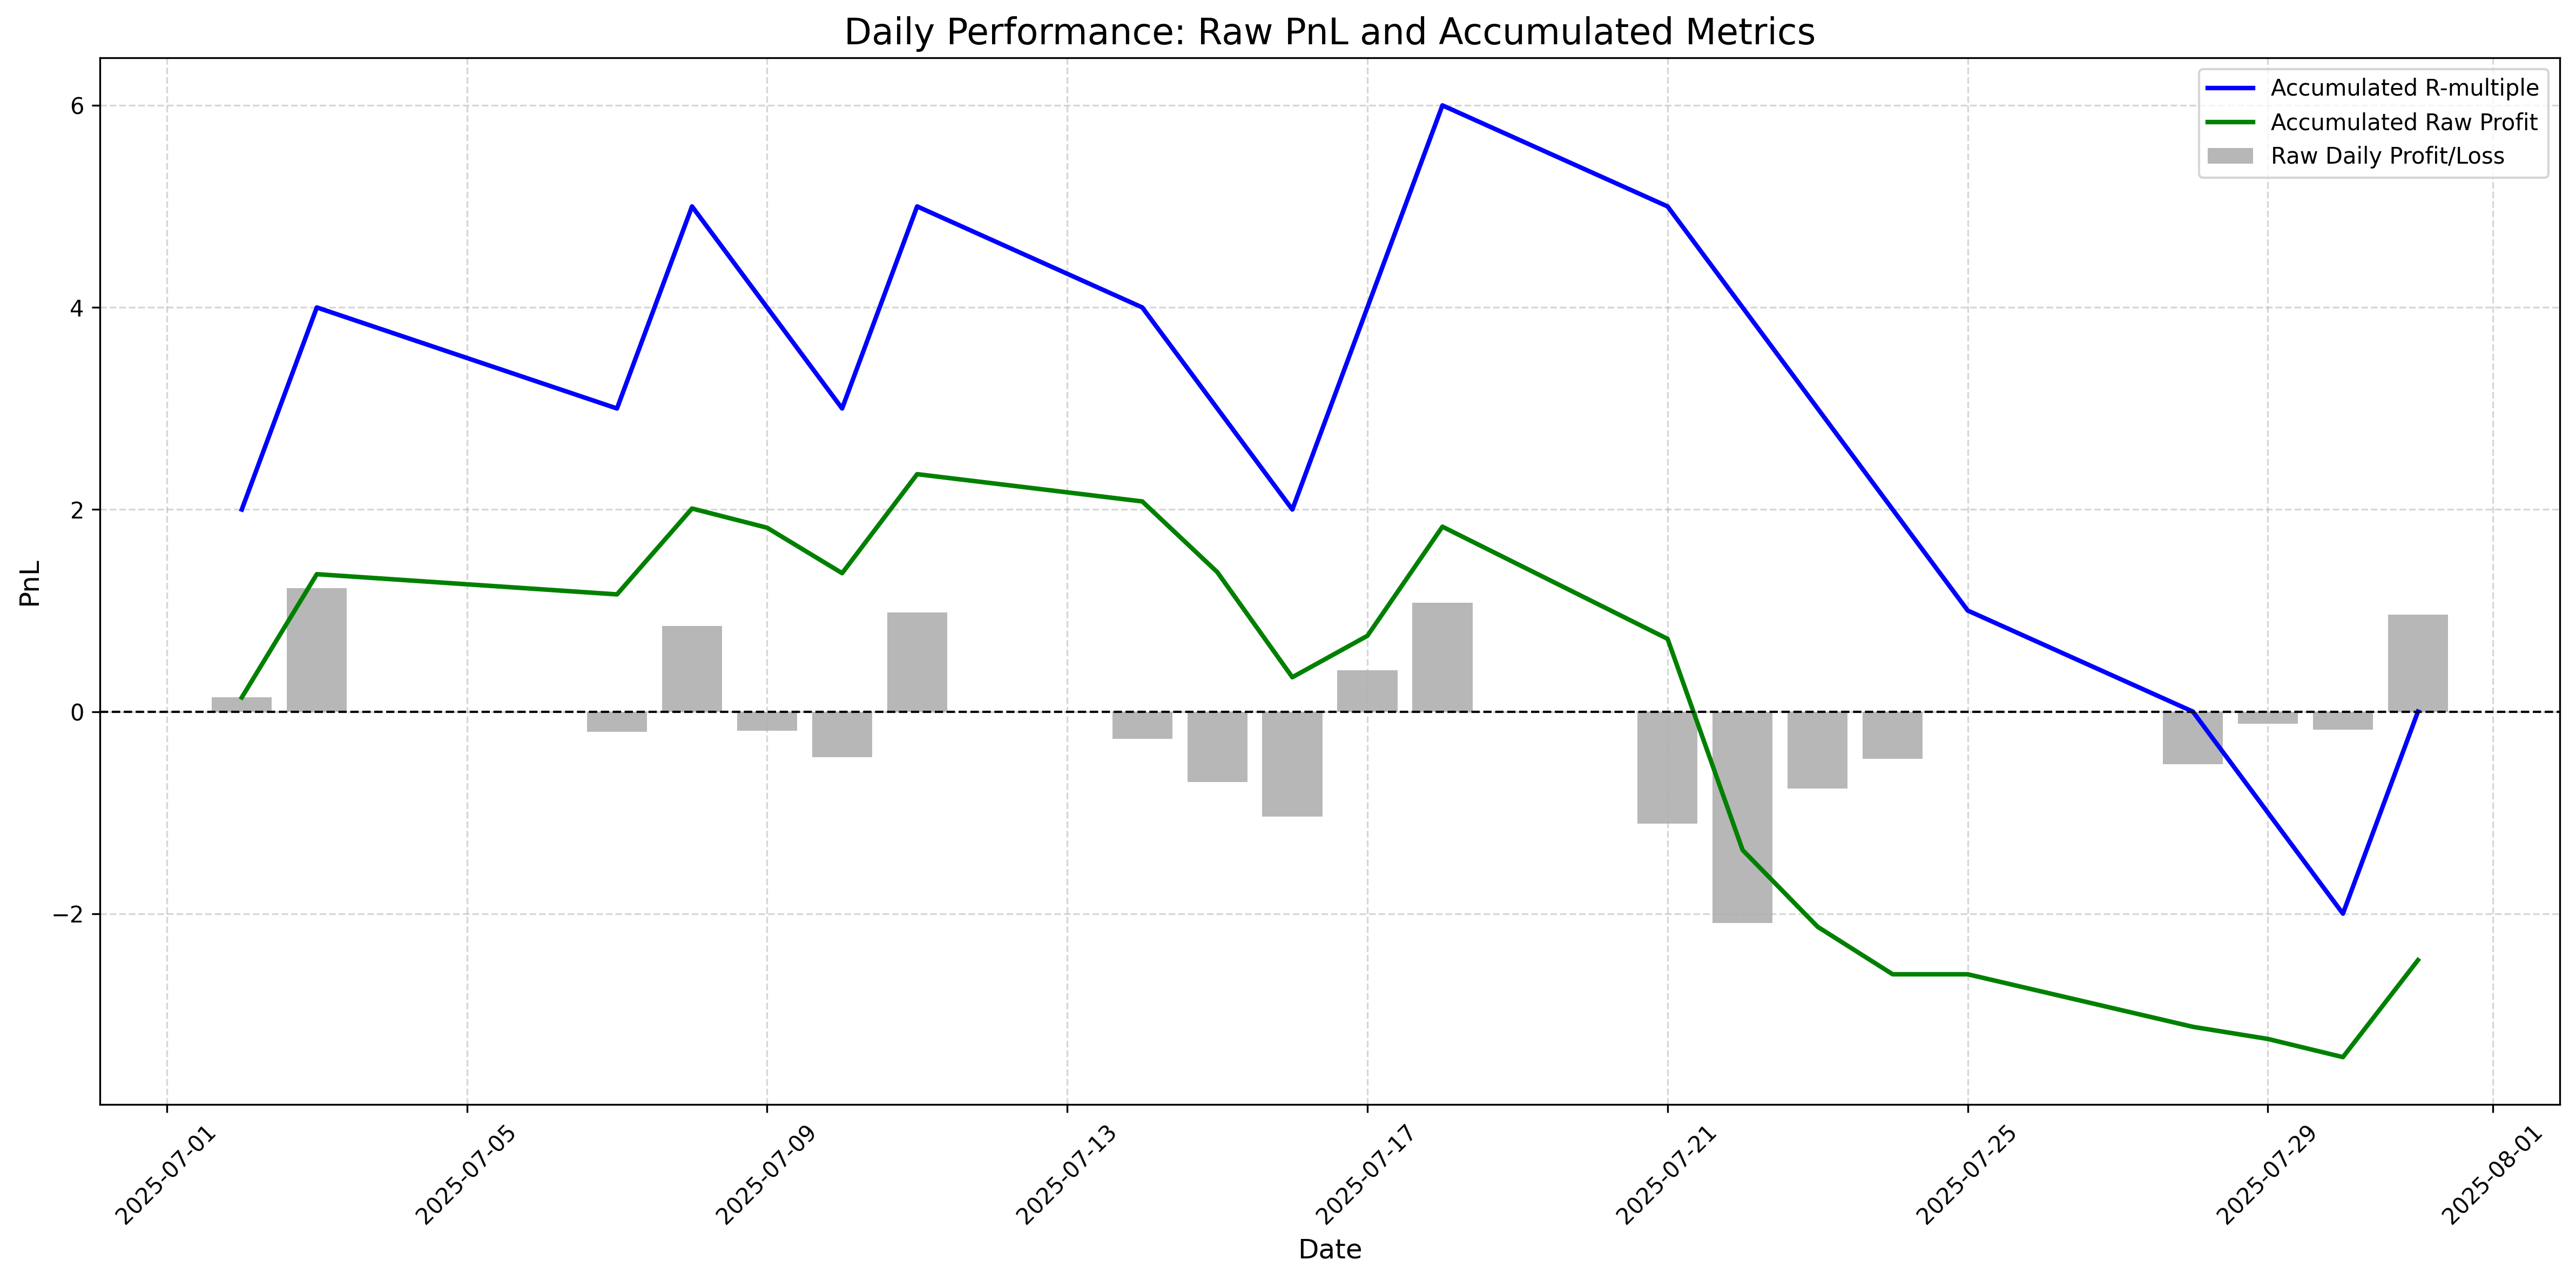

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)

# Ensure 'date' is datetime
trades_df["date"] = pd.to_datetime(trades_df["date"])

# Daily sums and cumulative totals
daily = trades_df.groupby("date")[["pnl_R", "pnl_abs"]].sum()
daily["cumulative_R"] = daily["pnl_R"].cumsum()
daily["cumulative_abs"] = daily["pnl_abs"].cumsum()

# Plotting
plt.figure(figsize=(16, 8), dpi=300)

# Bar for raw daily profit/loss
plt.bar(daily.index, daily["pnl_abs"], label="Raw Daily Profit/Loss", color="#888888", alpha=0.6)

# Line for cumulative R
plt.plot(daily.index, daily["cumulative_R"], label="Accumulated R-multiple", color="blue", linewidth=2)

# Line for cumulative raw profit/loss
plt.plot(daily.index, daily["cumulative_abs"], label="Accumulated Raw Profit", color="green", linewidth=2)

# Enhancements
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Daily Performance: Raw PnL and Accumulated Metrics", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("PnL", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
